In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf
import os
import databricks.koalas as ks

In [3]:
#pip install koalas

#### Enable Arrow-based columnar data transfer

In [ ]:
#spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [2]:
conf = SparkConf().setAppName("DanApp").setMaster("spark://172.25.0.101:7077")
sc = SparkContext(conf=conf)

In [5]:
sc._conf.getAll()

[('spark.app.name', 'DanApp'),
 ('spark.driver.port', '43883'),
 ('spark.app.id', 'app-20210123113131-0000'),
 ('spark.master', 'spark://172.25.0.101:7077'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '22c7f4043171'),
 ('spark.ui.showConsoleProgress', 'true')]

In [3]:
spark = SparkSession.builder \
    .master("spark://172.25.0.101:7077") \
    .appName("DanApp") \
    .getOrCreate()

In [4]:
spark.getActiveSession()

In [19]:
#for root, dirs, files in os.walk("."):
#    for filename in files:
#        print(filename)

## Describing Dataset

#### Creating a RDD from flat file

In [162]:
## Not working with double quote ""
## not working with header
rdd_mig_italy = sc.textFile("/home/jovyan/spark/MIG_ITALY_NO_QUOTE.csv", 4, use_unicode=True).repartition(6)

In [ ]:
rdd_mig_italy = rdd_mig_italy.filter(row => row != header)   #filter out header

In [156]:
print(type(rdd_mig_italy))

<class 'pyspark.rdd.RDD'>


In [157]:
rdd_mig_italy

MapPartitionsRDD[245] at coalesce at <unknown>:0

In [163]:
rdd_mig_italy.take(3)

['ITA,Italy,B13,Inflows of asylum seekers by nationality,TOT,Total,AUS,Australia,2015,2015,6',
 'ITA,Italy,B13,Inflows of asylum seekers by nationality,TOT,Total,AUS,Australia,2016,2016,24',
 'ITA,Italy,B13,Inflows of asylum seekers by nationality,TOT,Total,AUS,Australia,2019,2019,0']

In [159]:
rdd_mig_italy

MapPartitionsRDD[245] at coalesce at <unknown>:0

##### Schema RDD

In [165]:
fields = ('CO2','Country_Nationality','VAR','Variable','GEN','Gender','COU','Country','YEA','Year','Value')
from collections import namedtuple
Countries = namedtuple('Italy', fields )
def parseRecords( line ):
    fields = line.split(",")
    return Countries(fields[0], fields[1], fields[2], fields[3], fields[4],
                             fields[5], fields[6], fields[7], fields[8], fields[9], int(fields[10]))

df_rdd_mig_italy = rdd_mig_italy.map( lambda record: parseRecords(record) )
df_rdd_mig_italy.take(3)

[Italy(CO2='ITA', Country_Nationality='Italy', VAR='B13', Variable='Inflows of asylum seekers by nationality', GEN='TOT', Gender='Total', COU='AUS', Country='Australia', YEA='2015', Year='2015', Value=6),
 Italy(CO2='ITA', Country_Nationality='Italy', VAR='B13', Variable='Inflows of asylum seekers by nationality', GEN='TOT', Gender='Total', COU='AUS', Country='Australia', YEA='2016', Year='2016', Value=24),
 Italy(CO2='ITA', Country_Nationality='Italy', VAR='B13', Variable='Inflows of asylum seekers by nationality', GEN='TOT', Gender='Total', COU='AUS', Country='Australia', YEA='2019', Year='2019', Value=0)]

In [167]:
df_rdd_mig_italy_Country = df_rdd_mig_italy.filter( lambda record: record.Country == "Germany" )
df_rdd_mig_italy_Country.count()

112

In [274]:
rdd_countries = df_rdd_mig_italy.map( lambda record: (record.Country, record.Value) ).reduceByKey( lambda a, b: a+b)
rdd_countries_top10 = rdd_countries.filter( lambda record: record[1] > 1000000 )
list_countries_top10 = rdd_countries_top10.sortBy( lambda a: a[1]).collect()

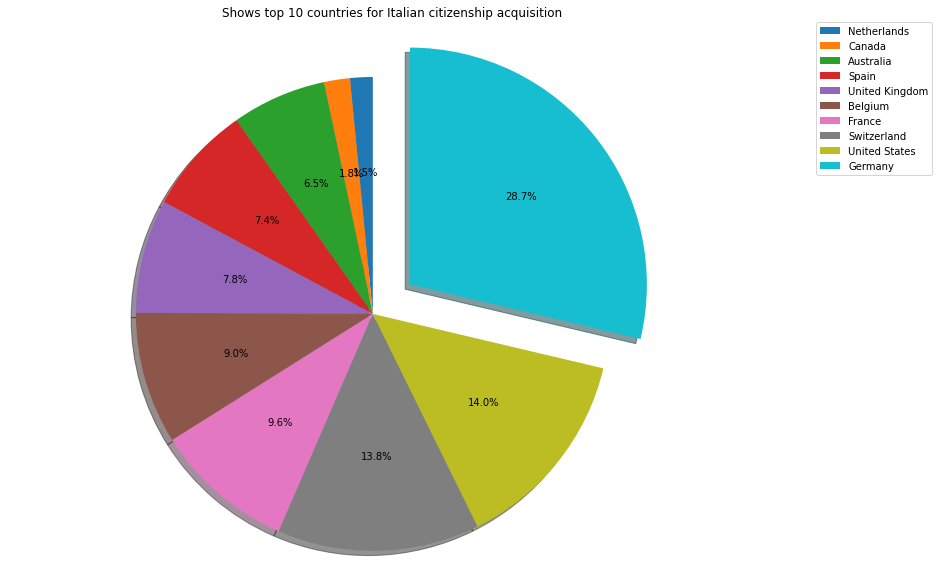

<Figure size 432x288 with 0 Axes>

In [303]:
from matplotlib import pyplot as plt
%matplotlib inline

image1== "italy-image1"
listCountries = []
listValues = []


fig1, ax1 = plt.subplots(1,1, figsize=(11,8))
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0 , 0.2)

for (a,b) in list_countries_top10:
    listCountries.append(a)
    listValues.append(b)
ax1.pie(listValues, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)

plt.tight_layout()
plt.title('Shows top 10 countries for Italian citizenship acquisition')

plt.legend(labels=listCountries, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax1.axis('equal')
plt.show()
plt.savefig(image1)

### Generating HTML

In [294]:
html_body = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h1>Italian citizenship acquisition</h1>

        <!-- ### Section 1 ### --->
        <h2>Graphic 1: Shows top 10 countries for Italian citizenship acquisition</h2>
        <iframe width="1100" height="800" frameborder="0" seamless="seamless" scrolling="no" \
src="''' + image1 + '''"></iframe>
    </body>
</html>'''
file = open('./Report-Italy.html','w')
file.write(html_body)
file.close()

##### Creating Spark Dataframe from flat file

In [6]:
skdf_mig_italy = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("/home/jovyan/spark/MIG_ITALY.csv")

In [7]:
print(type(skdf_mig_italy))

<class 'pyspark.sql.dataframe.DataFrame'>


In [9]:
skdf_mig_italy.show(2,truncate= True)

+---+----------------------------+---+--------------------+---+------+---+---------+----+----+-----+----------+-----+
|CO2|Country of birth/nationality|VAR|            Variable|GEN|Gender|COU|  Country| YEA|Year|Value|Flag Codes|Flags|
+---+----------------------------+---+--------------------+---+------+---+---------+----+----+-----+----------+-----+
|ITA|                       Italy|B11|Inflows of foreig...|TOT| Total|AUS|Australia|2000|2000|  299|      null| null|
|ITA|                       Italy|B11|Inflows of foreig...|TOT| Total|AUS|Australia|2001|2001|  400|      null| null|
+---+----------------------------+---+--------------------+---+------+---+---------+----+----+-----+----------+-----+
only showing top 2 rows



In [8]:
skdf_mig_italy.printSchema()

root
 |-- CO2: string (nullable = true)
 |-- Country of birth/nationality: string (nullable = true)
 |-- VAR: string (nullable = true)
 |-- Variable: string (nullable = true)
 |-- GEN: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- COU: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- YEA: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Value: integer (nullable = true)
 |-- Flag Codes: string (nullable = true)
 |-- Flags: string (nullable = true)



In [9]:
skdf_mig_italy.count()

2702

In [10]:
len(skdf_mig_italy.columns),skdf_mig_italy.columns

(13,
 ['CO2',
  'Country of birth/nationality',
  'VAR',
  'Variable',
  'GEN',
  'Gender',
  'COU',
  'Country',
  'YEA',
  'Year',
  'Value',
  'Flag Codes',
  'Flags'])

In [11]:
skdf_mig_italy.describe('Value').show()

+-------+------------------+
|summary|             Value|
+-------+------------------+
|  count|              2702|
|   mean|25439.251665433014|
| stddev|  83199.4019363038|
|    min|                 0|
|    max|            643530|
+-------+------------------+



In [12]:
skdf_mig_italy.select("Country" ,"Value").show(2)

+---------+-----+
|  Country|Value|
+---------+-----+
|Australia|  299|
|Australia|  400|
+---------+-----+
only showing top 2 rows



In [13]:
skdf_mig_italy.select("Variable").dropDuplicates().show(truncate= False)

+-----------------------------------------------------------+
|Variable                                                   |
+-----------------------------------------------------------+
|Stock of foreign population by nationality                 |
|Stock of foreign-born population by country of birth       |
|Outflows of foreign population by nationality              |
|Inflows of asylum seekers by nationality                   |
|Acquisition of nationality by country of former nationality|
|Inflows of foreign population by nationality               |
+-----------------------------------------------------------+



In [14]:
skdf_mig_italy.filter(skdf_mig_italy.Variable=="Acquisition of nationality by country of former nationality").count()

507

In [15]:
skdf_mig_italy.crosstab("Country","Year").show()

+---------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|   Country_Year|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|
+---------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|         Poland|   2|   3|   2|   3|   2|   2|   2|   3|   4|   3|   3|   2|   3|   3|   3|   3|   3|   2|   3|   1|   0|
|     Luxembourg|   4|   4|   5|   4|   4|   4|   4|   4|   4|   4|   4|   5|   5|   5|   5|   5|   5|   5|   6|   3|   0|
|  United States|   4|   4|   4|   4|   4|   5|   5|   5|   5|   5|   5|   5|   5|   5|   5|   5|   5|   4|   3|   2|   0|
|         Greece|   2|   3|   2|   2|   2|   2|   2|   2|   2|   3|   4|   4|   4|   3|   4|   3|   3|   1|   2|   1|   0|
|          Japan|   0|   0|   0|   0|   0|   0|   2|   3|   3|   3|   3|   3|   4|   4|   4|   4|   4|   3|   3|   1|   0|
|          Spain

In [16]:
skdf_mig_italy.groupby('Country').agg({'Value': 'sum'}).collect()

[Row(Country='Sweden', sum(Value)=309147),
 Row(Country='Turkey', sum(Value)=44973),
 Row(Country='Germany', sum(Value)=18810323),
 Row(Country='France', sum(Value)=6271734),
 Row(Country='Greece', sum(Value)=73696),
 Row(Country='Belgium', sum(Value)=5905870),
 Row(Country='Finland', sum(Value)=71797),
 Row(Country='United States', sum(Value)=9192897),
 Row(Country='Chile', sum(Value)=13453),
 Row(Country='Italy', sum(Value)=0),
 Row(Country='Norway', sum(Value)=130627),
 Row(Country='Spain', sum(Value)=4854220),
 Row(Country='Denmark', sum(Value)=234891),
 Row(Country='Ireland', sum(Value)=56818),
 Row(Country='Iceland', sum(Value)=11826),
 Row(Country='Israel', sum(Value)=51761),
 Row(Country='Mexico', sum(Value)=92805),
 Row(Country='Estonia', sum(Value)=20432),
 Row(Country='Switzerland', sum(Value)=9038454),
 Row(Country='Latvia', sum(Value)=6895),
 Row(Country='Canada', sum(Value)=1162452),
 Row(Country='Czech Republic', sum(Value)=56931),
 Row(Country='Slovenia', sum(Value)=104

In [17]:
# Fake sample
skdf_mig_italy.select('Country').rdd.map(lambda x:(x,1)).take(2)

[(Row(Country='Australia'), 1), (Row(Country='Australia'), 1)]

In [18]:
skdf_mig_italy.orderBy(skdf_mig_italy.Year, ascending = False).show(5)

+---+----------------------------+---+--------------------+---+------+---+---------------+----+----+-----+----------+-----+
|CO2|Country of birth/nationality|VAR|            Variable|GEN|Gender|COU|        Country| YEA|Year|Value|Flag Codes|Flags|
+---+----------------------------+---+--------------------+---+------+---+---------------+----+----+-----+----------+-----+
|ITA|                       Italy|B14|Stock of foreign-...|TOT| Total|DNK|        Denmark|2020|2020| 8991|      null| null|
|ITA|                       Italy|B15|Stock of foreign ...|TOT| Total|SVK|Slovak Republic|2020|2020| 3033|      null| null|
|ITA|                       Italy|B14|Stock of foreign-...|TOT| Total|SVK|Slovak Republic|2020|2020| 4028|      null| null|
|ITA|                       Italy|B15|Stock of foreign ...|TOT| Total|NOR|         Norway|2020|2020| 6302|      null| null|
|ITA|                       Italy|B15|Stock of foreign ...|TOT| Total|CZE| Czech Republic|2020|2020| 5682|      null| null|
+---+---

In [19]:
skdf_mig_italy.withColumn('Value_new', skdf_mig_italy.Value /2.0).select('Value','Value_new').show(5)

+-----+---------+
|Value|Value_new|
+-----+---------+
|  299|    149.5|
|  400|    200.0|
|  586|    293.0|
|  393|    196.5|
|  494|    247.0|
+-----+---------+
only showing top 5 rows



In [20]:
skdf_mig_italy.drop('Value').columns

['CO2',
 'Country of birth/nationality',
 'VAR',
 'Variable',
 'GEN',
 'Gender',
 'COU',
 'Country',
 'YEA',
 'Year',
 'Flag Codes',
 'Flags']

In [21]:
skdf_mig_italy.printSchema()

root
 |-- CO2: string (nullable = true)
 |-- Country of birth/nationality: string (nullable = true)
 |-- VAR: string (nullable = true)
 |-- Variable: string (nullable = true)
 |-- GEN: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- COU: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- YEA: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Value: integer (nullable = true)
 |-- Flag Codes: string (nullable = true)
 |-- Flags: string (nullable = true)



## Key-Value Transformations

In [22]:
skdf_mig_italy.select('Country','Year','Value').rdd.map(lambda x:(x[0], x[1], x[2])).take(2)

[('Australia', 2000, 299), ('Australia', 2001, 400)]

In [23]:
skdf_mig_italy.select('Country','Year','Value').rdd.map(lambda x:(x,1)).take(2)

[(Row(Country='Australia', Year=2000, Value=299), 1),
 (Row(Country='Australia', Year=2001, Value=400), 1)]

In [24]:
mig_italy_country_total = skdf_mig_italy.select('Country','Value').rdd.reduceByKey(lambda x, y: x + y)

In [25]:
type(mig_italy_country_total)

pyspark.rdd.PipelinedRDD

In [91]:
#

In [26]:
skdf_mig_italy.select('Country','Value').rdd.groupByKey().take(5)

[('Australia', <pyspark.resultiterable.ResultIterable at 0x7ff525ab0ca0>),
 ('Austria', <pyspark.resultiterable.ResultIterable at 0x7ff525ab0850>),
 ('Belgium', <pyspark.resultiterable.ResultIterable at 0x7ff525ab0b20>),
 ('Canada', <pyspark.resultiterable.ResultIterable at 0x7ff525ab01f0>),
 ('Czech Republic', <pyspark.resultiterable.ResultIterable at 0x7ff525ab0e20>)]

In [27]:
skdf_mig_italy.select('Country','Value').rdd.filter(lambda x:x[1]<100).take(5)

[Row(Country='Australia', Value=25),
 Row(Country='Australia', Value=39),
 Row(Country='Australia', Value=11),
 Row(Country='Australia', Value=4),
 Row(Country='Australia', Value=7)]

####  Creating Koala DataFrame from flat file

In [30]:
kdf_mig_italy = ks.read_csv("/home/jovyan/spark/MIG_ITALY.csv")

In [31]:
type(kdf_mig_italy)

databricks.koalas.frame.DataFrame

In [28]:
#kdf_mig_italy.Country.unique()

In [32]:
kdf_mig_italy.info()

<class 'databricks.koalas.frame.DataFrame'>
Index: 2702 entries, 0 to 2701
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   CO2                           2702 non-null   object
 1   Country of birth/nationality  2702 non-null   object
 2   VAR                           2702 non-null   object
 3   Variable                      2702 non-null   object
 4   GEN                           2702 non-null   object
 5   Gender                        2702 non-null   object
 6   COU                           2702 non-null   object
 7   Country                       2702 non-null   object
 8   YEA                           2702 non-null   int32 
 9   Year                          2702 non-null   int32 
 10  Value                         2702 non-null   int32 
 11  Flag Codes                    0 non-null      object
 12  Flags                         0 non-null      object
dtypes: int32(3), obje

## Data Cleaning

In [33]:
# Koalas do not support pandas Categorical date type
kdf_mig_italy = kdf_mig_italy[["Country of birth/nationality","VAR","Variable","GEN","Gender","COU","Country","Year","Value"]]

# Converting to pandas because Plotly no support Koalas
pddf_mig_italy = kdf_mig_italy.to_pandas()
pddf_mig_italy["Rank"] = pddf_mig_italy["Value"].rank(method ='min') 


In [34]:
pddf_mig_italy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702 entries, 0 to 2701
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country of birth/nationality  2702 non-null   object 
 1   VAR                           2702 non-null   object 
 2   Variable                      2702 non-null   object 
 3   GEN                           2702 non-null   object 
 4   Gender                        2702 non-null   object 
 5   COU                           2702 non-null   object 
 6   Country                       2702 non-null   object 
 7   Year                          2702 non-null   int32  
 8   Value                         2702 non-null   int32  
 9   Rank                          2702 non-null   float64
dtypes: float64(1), int32(2), object(7)
memory usage: 211.1+ KB


In [20]:
#pip install plotly-geo

### Plot

In [110]:
#import plotly as py
#pip install "notebook>=5.3" "ipywidgets>=7.5"
#pip install chart-studio

In [42]:
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

In [43]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Use Plotly locally
cf.go_offline()

In [44]:
df_mig_italy_country_total = mig_italy_country_total.toDF()
sqlContext.createDataFrame(rdd, schema)

In [45]:
df_mig_italy_country_total.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: long (nullable = true)



In [46]:
display(df_mig_italy_country_total)

DataFrame[_1: string, _2: bigint]

In [52]:
fig = go.Figure()

data = [go.Histogram(x=df_mig_italy_country_total.toPandas().items())]


py.iplot(data, filename = 'CountryTotal.html', validate = False)

ValueError: 
    Invalid value of type 'builtins.generator' received for the 'x' property of histogram
        Received value: <generator object DataFrame.items at 0x7ff5189333c0>

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [97]:
fig = go.Figure()
px.bar(pddf_mig_italy.query("Country == ('Germany','United States','France')")
        , x="Year", y="Value", color="Country")

#fig.add_trace(go.Scatter(x=pddf_mig_italy.Year, y=pddf_mig_italy.Value, 
#                         mode = 'lines',name='Test1'))
#fig.add_trace(go.Scatter(x=pddf_mig_italy.Year, y=pddf_mig_italy.Value, 
#                         name='Test2', line=dict(color='firebrick', width=2, dash='dashdot')))

In [ ]:
mig_italy_country_total.sort_values("Value",ascending = False).head(2)

In [103]:
fig = px.bar(pddf_mig_italy
        , x="Country", y="Value",color="Country")
fig.update_traces(texttemplate='%{text:.2s}',textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

### Geo Map

#### Filtering

In [17]:
kdf_mig_italy[kdf_mig_italy["Year"]==2019].groupby("Variable").sum()

,Year,Value
Variable,,
Stock of foreign population by nationality,44418,1538353
Stock of foreign-born population by country of birth,40380,1690888
Outflows of foreign population by nationality,6057,325
Inflows of asylum seekers by nationality,58551,193
Acquisition of nationality by country of former nationality,14133,6001
Inflows of foreign population by nationality,10095,3171


In [70]:
#pip install geopandas
#pip install mapclassify
#pip install descartes

In [93]:
pddf_mig_italy_2019 = kdf_mig_italy[(kdf_mig_italy["Variable"]=="Acquisition of nationality by country of former nationality") &
                                  (kdf_mig_italy["Year"]==2019)][["Country","Year","Value"]].to_pandas()

In [94]:
type(pddf_mig_italy_2019)

pandas.core.frame.DataFrame

In [20]:
import geopandas as gpd
import pandas as pd

In [31]:
world.count()

pop_est       176
continent     176
name          176
iso_a3        176
gdp_md_est    176
geometry      176
dtype: int64

In [32]:
pddf_mig_italy_2019.count()

Country    7
Year       7
Value      7
dtype: int64

In [65]:
world_italy_2019.groupby("Value").count()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country,Year
Value,,,,,,,,
0.0,171,171,171,171,171,171,1,1
3.0,0,0,0,0,0,0,1,1
6.0,1,1,1,1,1,1,1,1
17.0,1,1,1,1,1,1,1,1
246.0,1,1,1,1,1,1,1,1
1254.0,1,1,1,1,1,1,1,1
4475.0,1,1,1,1,1,1,1,1


In [38]:
#world_italy_2019.head(5)

* Acquisition of nationality by country of former nationality of year 2019

In [95]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
world_italy_2019 = pd.merge(world,
                        pddf_mig_italy_2019, 
                        how="outer", # "outer"  "right"
                        left_on=["name"], 
                        right_on=["Country"])
world_italy_2019['Value'] = world_italy_2019['Value'].fillna(0)

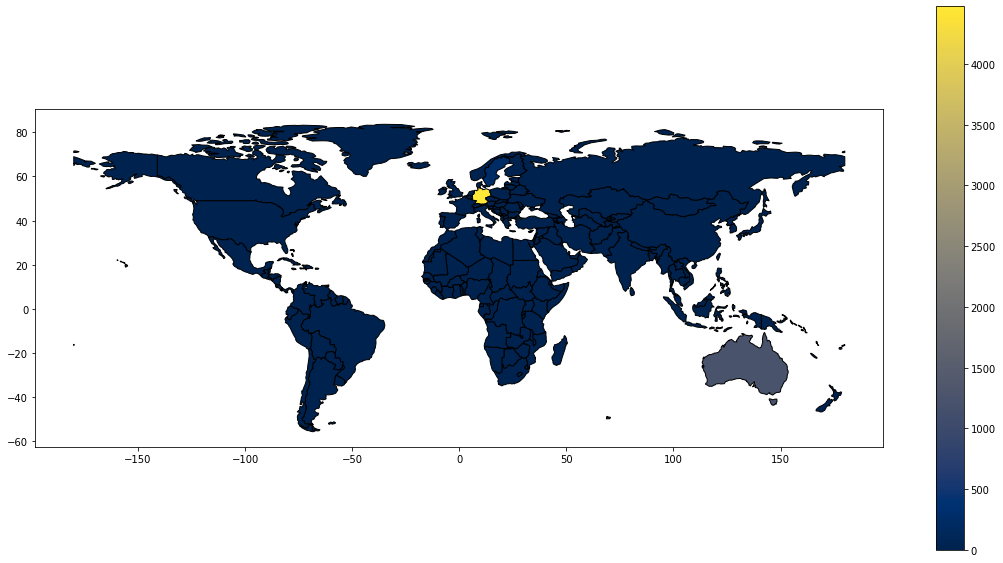

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(19,10))

world_italy_2019.plot(column='Value',
                  ax=ax, 
                  edgecolor="black",
                  cmap='cividis',
                  legend=True,                     
                 );                  

In [5]:
world_italy_2019.plot(marker='*', color='green', markersize=5);

world_italy_2019 = world_italy_2019.to_crs(world.crs)

fig, ax = plt.subplots()

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')
world_italy_2019.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show();

NameError: name 'world_italy_2019' is not defined

In [17]:
rdd = sc.parallelize([2,3,4])
print(type(rdd))
print(rdd.take(5))

<class 'pyspark.rdd.RDD'>
[2, 3, 4]


In [52]:
print(type(sc),"\n")
print(dir(sc),"\n")
print(sc.version,"\n")
sc.getConf().getAll()

<class 'pyspark.context.SparkContext'> 

['PACKAGE_EXTENSIONS', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_accumulatorServer', '_active_spark_context', '_assert_on_driver', '_batchSize', '_callsite', '_checkpointFile', '_conf', '_dictToJavaMap', '_do_init', '_encryption_enabled', '_ensure_initialized', '_gateway', '_getJavaStorageLevel', '_initialize_context', '_javaAccumulator', '_jsc', '_jvm', '_lock', '_next_accum_id', '_pickled_broadcast_vars', '_python_includes', '_repr_html_', '_serialize_to_jvm', '_temp_dir', '_unbatched_serializer', 'accumulator', 'addFile', 'addPyFile', 'appName', 'applicationId', 'binaryFiles', 'binaryRecords', 'broadca

[('spark.app.name', 'DanApp'),
 ('spark.app.id', 'app-20210112100630-0002'),
 ('spark.master', 'spark://172.25.0.101:7077'),
 ('spark.driver.port', '37413'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '99b27e601ea9'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]